# Uplift prediction on the Hillstrom's MineThatData E-Mail Analytics And Data Mining Challenge dataset using the CausalML package

## Introduction

The Hillstrom's MineThatData E-Mail Analytics And Data Mining Challenge dataset contains 64,000 customers involved in an e-mail campaign.
The customers are randomly divided into three equal groups:

* the first group receives an e-mail campaign on Mens merchandise;
* the second group receives an e-mail campaign on Womens merchandise;
* the third group does not receive any campaign.

Since the customers receiving a treatment have the same probability of belonging to one of the three segments, the propensity score is known.

In this test we consider only one e-mail campaign at a time, therefore we exclude the individuals having received the other treatment.
This means that the propensity score of each customer is 0.5.

## Meta-Learners

In this first test, we use the Meta-Learners from the CausalML package. In particular, we use:

* S-Learner
* T-Learner
* X-Learner with propensity score
* R-Learner with propensity score


In [16]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.tree import UpliftRandomForestClassifier, uplift_tree_plot
from causalml.metrics import plot_gain, auuc_score

from IPython.display import Image
import warnings
warnings.simplefilter("ignore", UserWarning)

%matplotlib inline

In [17]:
from datasets import HillstromDataset

### Loading the data

We choose which campaign to analyze by changing the *campaign* parameter of *getCampaignData*. By choosing 1, we target
the Mens campaign, while by choosing 2 we target the Womens campaign.

We define the following vectors:
* y, the outcome
* X, the features
* w, the treatment indicator
* p, the propensity score

We split the data into a train set and a test set. In this test, the two sets have equal size.

In [18]:
data = HillstromDataset()
y_train, X_train, w_train, y_test, X_test, w_test = data.getTrainTest(campaign=1)
p_train = np.full(shape=y_train.size, fill_value=0.5)
p_test = np.full(shape=y_test.size, fill_value=0.5)


### CATE estimation

We initialize our Meta-Learners using a Linear Regression model and we estimate the CATE. To do so, we train the model with the train set
and we predict the CATE on the test set.

In [19]:
# S Learner
learner_s = BaseSRegressor(learner=LinearRegression())
learner_s.fit(X=X_train, treatment=w_train, y=y_train)
cate_s_test = learner_s.predict(X=X_test, treatment=w_test)

# T Learner
learner_t = BaseTRegressor(learner=LinearRegression())
learner_t.fit(X=X_train, treatment=w_train, y=y_train)
cate_t_test = learner_t.predict(X=X_test, treatment=w_test)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=LinearRegression())
learner_x.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_x_test = learner_x.predict(X=X_test, treatment=w_test, p=p_test)

# R Learner with propensity score input
learner_r = BaseRRegressor(learner=LinearRegression())
learner_r.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_r_test = learner_r.predict(X=X_test, p=p_test)

### Uplift curve

We plot the uplift curve by using the dedicated function from the CausalML package. We estimate the area under the curve
to compare the different models.

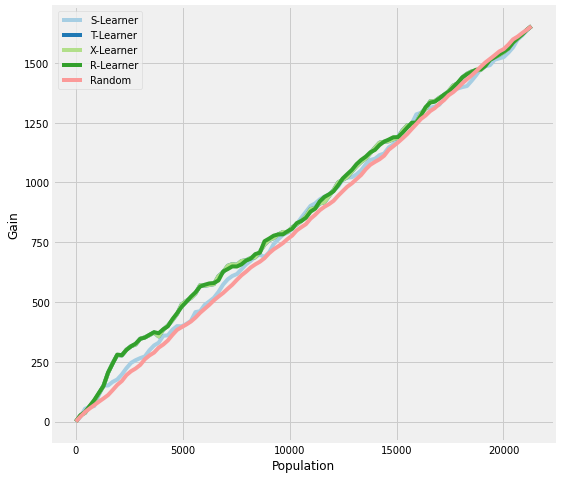

In [20]:
df = pd.DataFrame({'y': y_test, 'w': w_test, 'S-Learner': cate_s_test.flatten(),
                   'T-Learner': cate_t_test.flatten(), 'X-Learner': cate_x_test.flatten(), 'R-Learner': cate_r_test.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

In [21]:
print("Area under the uplift curves:")
auuc_score(df, outcome_col='y', treatment_col='w')

Area under the uplift curves:


S-Learner    0.512377
T-Learner    0.529506
X-Learner    0.529506
R-Learner    0.529570
Random       0.502244
dtype: float64

We repeat the same process, this time we replace the Linear Regression model by a k-Nearest Neighbors model.

Note: the KNeighbors model from sklearn does not allow to fit using sample weights, therefore it does not work with R-Learner.

In [22]:
# S Learner
learner_s = BaseSRegressor(learner=KNeighborsRegressor())
learner_s.fit(X=X_train, treatment=w_train, y=y_train)
cate_s_test = learner_s.predict(X=X_test, treatment=w_test)

# T Learner
learner_t = BaseTRegressor(learner=KNeighborsRegressor())
learner_t.fit(X=X_train, treatment=w_train, y=y_train)
cate_t_test = learner_t.predict(X=X_test, treatment=w_test)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=KNeighborsRegressor())
learner_x.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_x_test = learner_x.predict(X=X_test, treatment=w_test, p=p_test)

# R Learner with propensity score input
learner_r = BaseRRegressor(learner=KNeighborsRegressor())
#learner_r.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
#cate_r_test = learner_r.predict(X=X_test, p=p_test)


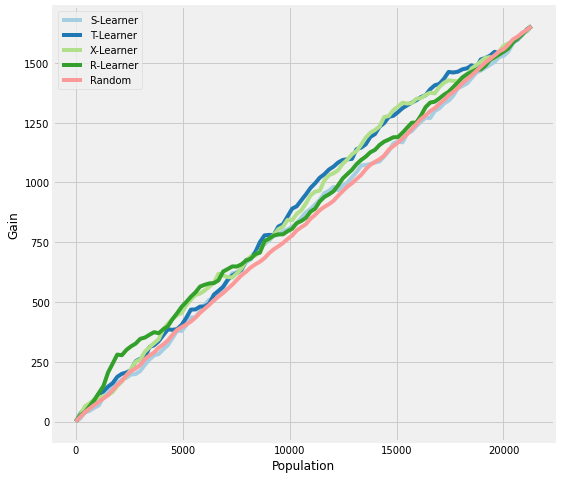

In [23]:
df = pd.DataFrame({'y': y_test, 'w': w_test, 'S-Learner': cate_s_test.flatten(),
                   'T-Learner': cate_t_test.flatten(), 'X-Learner': cate_x_test.flatten(), 'R-Learner': cate_r_test.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

In [24]:
print("Area under the uplift curves:")
auuc_score(df, outcome_col='y', treatment_col='w')

Area under the uplift curves:


S-Learner    0.506209
T-Learner    0.538815
X-Learner    0.538783
R-Learner    0.529570
Random       0.502244
dtype: float64

## Uplift Random Forest on Contextual Treatment Selection

In this test, we use the Uplift Tree from the CausalML package. As a splitting criterion, we choose CTS (Contextual Treatment Selection).

In [25]:
uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='CTS')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
y_pred = uplift_model.predict(X=X_test)

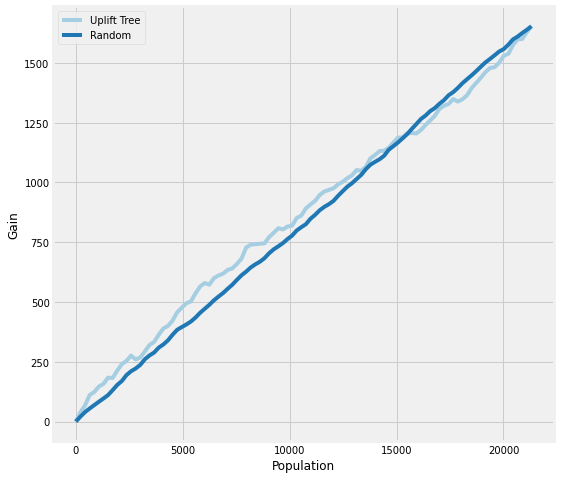

In [26]:
df = pd.DataFrame({'y': y_test, 'w': w_test, 'Uplift Tree': y_pred.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

In [27]:
print("Area under the uplift curves:")
auuc_score(df, outcome_col='y', treatment_col='w')

Area under the uplift curves:


Uplift Tree    0.521040
Random         0.502244
dtype: float64

## Comparison between the two campaigns

For comparison, we repeat here the same steps by chosing the Womens campaign.

In [28]:
data = HillstromDataset()
y_train, X_train, w_train, y_test, X_test, w_test = data.getTrainTest(campaign=2)
p_train = np.full(shape=y_train.size, fill_value=0.5)
p_test = np.full(shape=y_test.size, fill_value=0.5)


### Meta-Learners with Linear Regression

In [29]:
# S Learner
learner_s = BaseSRegressor(learner=LinearRegression())
learner_s.fit(X=X_train, treatment=w_train, y=y_train)
cate_s_test = learner_s.predict(X=X_test, treatment=w_test)

# T Learner
learner_t = BaseTRegressor(learner=LinearRegression())
learner_t.fit(X=X_train, treatment=w_train, y=y_train)
cate_t_test = learner_t.predict(X=X_test, treatment=w_test)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=LinearRegression())
learner_x.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_x_test = learner_x.predict(X=X_test, treatment=w_test, p=p_test)

# R Learner with propensity score input
learner_r = BaseRRegressor(learner=LinearRegression())
learner_r.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_r_test = learner_r.predict(X=X_test, p=p_test)

Uplift curves for Meta-Learners with Linear Regression

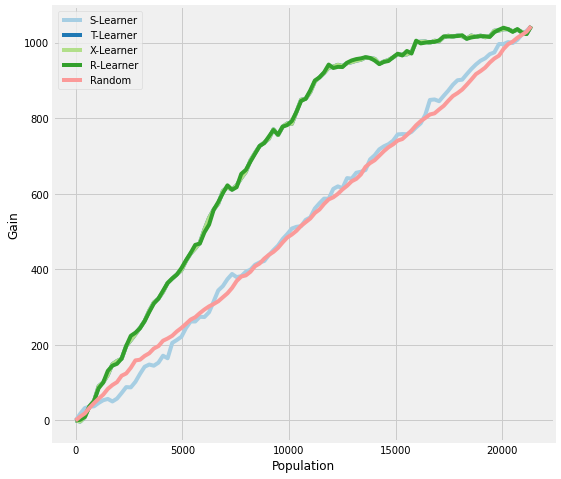

In [30]:
df = pd.DataFrame({'y': y_test, 'w': w_test, 'S-Learner': cate_s_test.flatten(),
                   'T-Learner': cate_t_test.flatten(), 'X-Learner': cate_x_test.flatten(), 'R-Learner': cate_r_test.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

In [31]:
print("Area under the uplift curves:")
auuc_score(df, outcome_col='y', treatment_col='w')

Area under the uplift curves:


S-Learner    0.502485
T-Learner    0.679605
X-Learner    0.679605
R-Learner    0.679715
Random       0.500102
dtype: float64

### Meta Learners with k-Neighbors Regression

In [32]:
# S Learner
learner_s = BaseSRegressor(learner=KNeighborsRegressor())
learner_s.fit(X=X_train, treatment=w_train, y=y_train)
cate_s_test = learner_s.predict(X=X_test, treatment=w_test)

# T Learner
learner_t = BaseTRegressor(learner=KNeighborsRegressor())
learner_t.fit(X=X_train, treatment=w_train, y=y_train)
cate_t_test = learner_t.predict(X=X_test, treatment=w_test)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=KNeighborsRegressor())
learner_x.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_x_test = learner_x.predict(X=X_test, treatment=w_test, p=p_test)

# R Learner with propensity score input
learner_r = BaseRRegressor(learner=KNeighborsRegressor())
#learner_r.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
#cate_r_test = learner_r.predict(X=X_test, p=p_test)

Uplift curves for Meta-Learners with k-Neighbors Regression

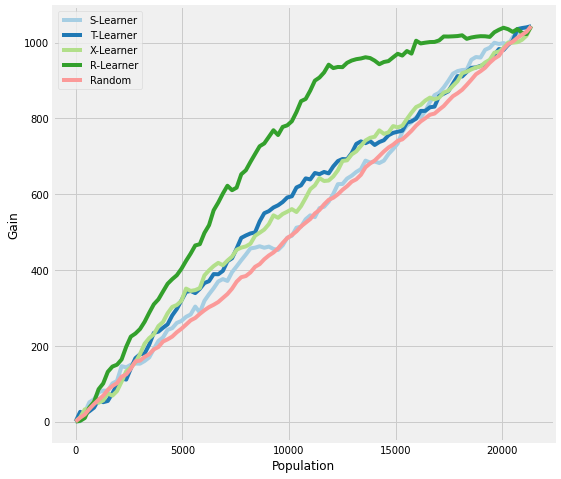

In [33]:
df = pd.DataFrame({'y': y_test, 'w': w_test, 'S-Learner': cate_s_test.flatten(),
                   'T-Learner': cate_t_test.flatten(), 'X-Learner': cate_x_test.flatten(), 'R-Learner': cate_r_test.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

In [34]:
print("Area under the uplift curves:")
auuc_score(df, outcome_col='y', treatment_col='w')

Area under the uplift curves:


S-Learner    0.518607
T-Learner    0.547339
X-Learner    0.544805
R-Learner    0.679715
Random       0.500102
dtype: float64

### Uplift Random Forest on Contextual Treatment Selection

In [35]:
uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='CTS')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
y_pred = uplift_model.predict(X=X_test)

Uplift curves for Uplift Random Forest with Contextual Treatment Selection

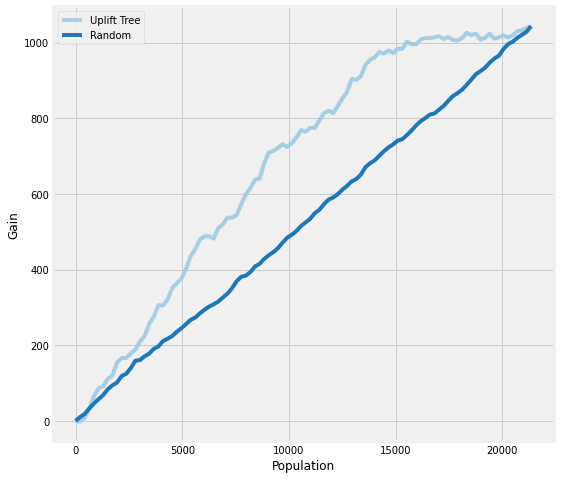

In [36]:
df = pd.DataFrame({'y': y_test, 'w': w_test, 'Uplift Tree': y_pred.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

In [37]:
print("Area under the uplift curves:")
auuc_score(df, outcome_col='y', treatment_col='w')

Area under the uplift curves:


Uplift Tree    0.651929
Random         0.500102
dtype: float64